In [ ]:
from ddnn.data import *
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib ipympl


dataset_type = ""
epochs = 500
torch.manual_seed(123)
if isinstance(dataset_type, tuple):
    traindata = read_monks(dataset_type[1], "train")
    traindata = onehot_encoding(data=traindata)

    testdata = read_monks(dataset_type[1], "test")
    testdata = onehot_encoding(data=testdata)
else:
    traindata = read_ML_cup("train")
    traindata, testdata = train_valid_split(traindata)
    blindtest = read_ML_cup("test")

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(traindata.data.shape[1], 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, traindata.labels.shape[1])
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
criterion = torch.nn.MSELoss()

# Converting inputs and labels to Variable
inputs = torch.tensor(traindata.data, dtype=torch.float32)
labels = torch.tensor(traindata.labels, dtype=torch.float32)

test = torch.tensor(testdata.data, dtype=torch.float32)
testlabels = torch.tensor(testdata.labels, dtype=torch.float32)

scores = []
for epoch in range(epochs):

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)

    test_loss = None
    with torch.no_grad():
        pred = model(test)
        test_loss = criterion(pred, testlabels)

    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    scores.append((loss.item(), test_loss.item()))

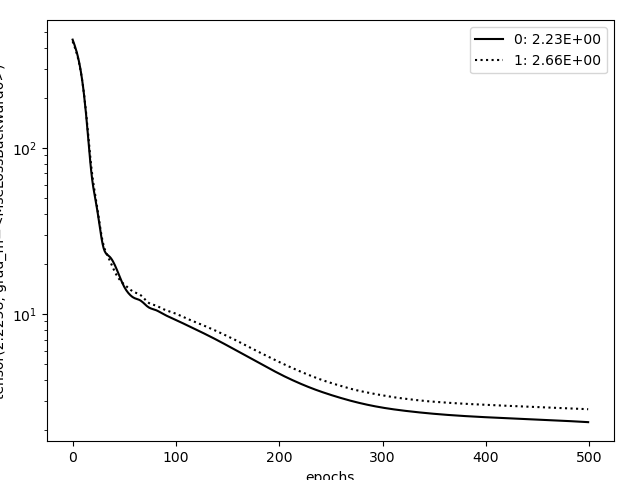

In [ ]:
# 1 plot with train and valid

fig, ax = plt.subplots()

def plot_results():
    fig.tight_layout()
    ax.clear()
    ax.set_xlabel("epochs")
    ax.set_ylabel(loss)
    for where, style in zip([0, 1], [None, "dotted"]):
        y = [score[where] for score in scores]
        if loss == "binary_accuracy":
            # todo fix to show last not best
            best = max(y)
            form = "{:.2}"
            logplot = False
        else:
            best = min(y)
            form = "{:.2E}"
            logplot = True
        # scale to resemble number of epochs instead of plot points
        ticks_x = ticker.FuncFormatter(
            lambda x, pos: '{0:g}'.format(x)
        )
        ax.xaxis.set_major_formatter(ticks_x)
        if logplot:
            ax.set_yscale("log")
        else:
            ax.set_yscale("linear")
        ax.plot(y, label=f"{where}: {form.format(best)}", 
            linestyle=style, color="black"
        )
        ax.legend()
plot_results()
